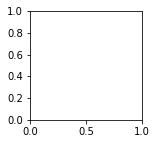

In [1]:
# import numpy as np

# # !/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on 20181219

# @author: zhangji

# Trajection of a ellipse, Jeffery equation. 
# """

# %pylab inline
# pylab.rcParams['figure.figsize'] = (25, 11)
# fontsize = 40

# import numpy as np
# import scipy as sp
# from scipy.optimize import leastsq, curve_fit
# from scipy import interpolate
# from scipy.interpolate import interp1d
# from scipy.io import loadmat, savemat
# # import scipy.misc

# import matplotlib
# from matplotlib import pyplot as plt
# from matplotlib import animation, rc
# import matplotlib.ticker as mtick
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
# from mpl_toolkits.mplot3d import Axes3D, axes3d

# from sympy import symbols, simplify, series, exp
# from sympy.matrices import Matrix
# from sympy.solvers import solve

# from IPython.display import display, HTML
# from tqdm import tqdm_notebook as tqdm
# import pandas as pd
# import re
# from scanf import scanf
# import os
# import glob

# from codeStore import support_fun as spf
# from src.support_class import *
# from src import stokes_flow as sf

# rc('animation', html='html5')
# PWD = os.getcwd()
# font = {'size': 20}
# matplotlib.rc('font', **font)
# np.set_printoptions(linewidth=90, precision=5)

%load_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm as tqdm_notebook
import os
import glob
import natsort 
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate, integrate
from scipy import spatial
# from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc
# import importlib
from IPython.display import display, HTML
import pandas as pd
import pickle

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm

from time import time
from src.support_class import *
from src import jeffery_model as jm
from codeStore import support_fun as spf
from codeStore import support_fun_table as spf_tb
from codeStore import support_fun_baseflow as spf_bf
# %matplotlib notebook

from sympy.parsing import mathematica
import sympy
from sympy.printing.latex import LatexPrinter, print_latex
from sympy.utilities.lambdify import lambdify, lambdastr
import inspect

%matplotlib inline
rc('animation', html='html5')
fontsize = 40
PWD = os.getcwd()
np.set_printoptions(linewidth=120, precision=5)

fig = plt.figure(figsize=(2, 2))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(1, 1, 1)

True

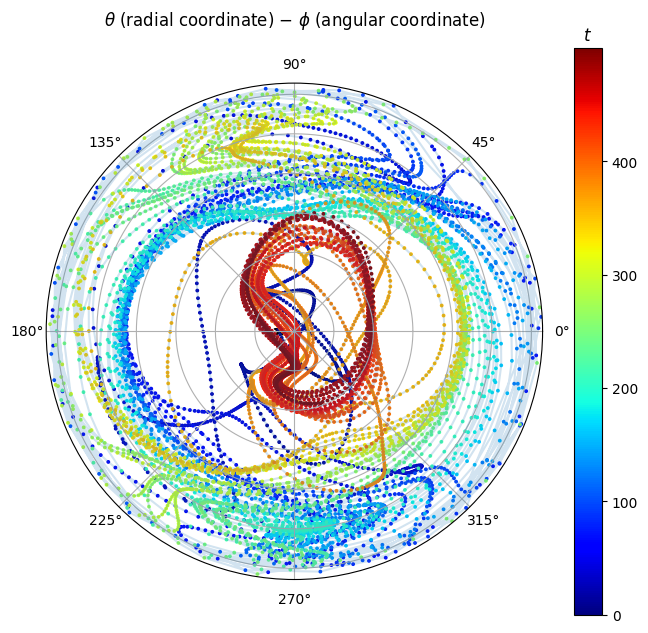

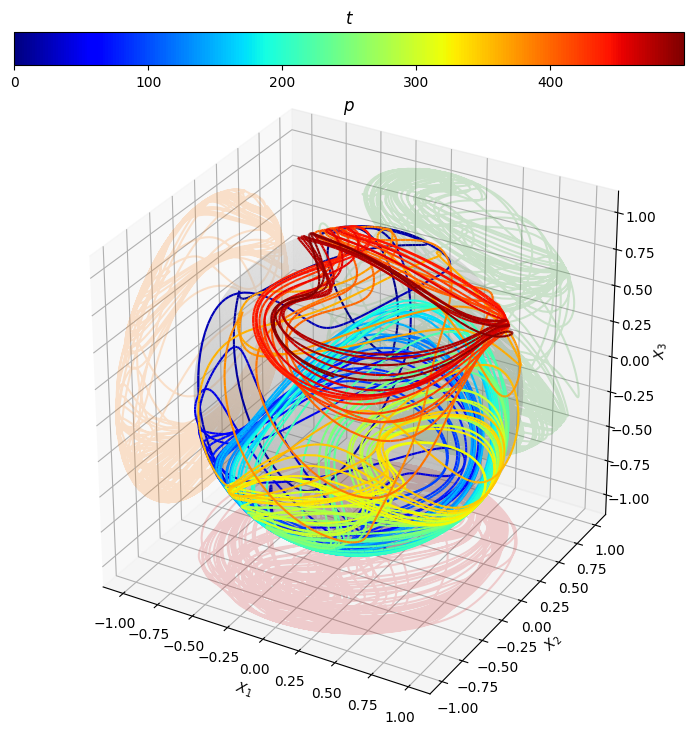

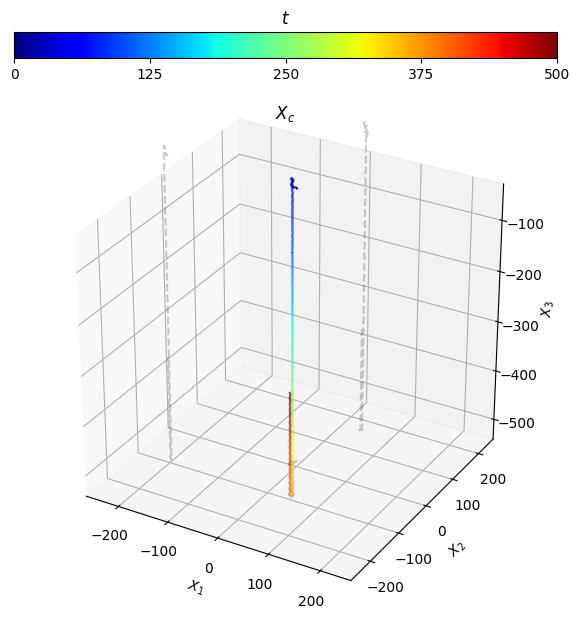

In [22]:
# matplotlib.use('nbAgg')
matplotlib.use('agg')
%matplotlib inline
# %matplotlib notebook

dpi = 100 
base_t_min, base_t_max = 0, 500

# pickle_dir = 'ecoB01B05_baseFlow/A1.00_B1.00_C1.00_w0.0000_rand_a'
# pickle_name = 'th0.08312_ph0.02208_ps3.03514_x4.25312_y0.67946_z5.02285.pickle'

pickle_dir = 'ecoB01B05_baseFlow/A1.00_B1.00_C1.00_w5.0000_rand_a2'
pickle_name = 'th0.20158_ph3.03596_ps0.89031_x0.54299_y2.55553_z5.03842.pickle'

pickle_path = os.path.join(pickle_dir, pickle_name)
with open(pickle_path, 'rb') as handle:
    tpick = pickle.load(handle)
base_t = tpick['base_t']
base_dt = tpick['base_dt']
base_X = tpick['base_X']
base_thphps = tpick['base_thphps']
base_U = tpick['base_U']
base_W = tpick['base_W']
base_psi_t = tpick['base_psi_t']

tidx = (base_t >= base_t_min) * (base_t <= base_t_max)
tdata = (base_t[tidx], base_dt[tidx], base_X[tidx], base_thphps[tidx], 
         base_U[tidx], base_W[tidx], base_psi_t[tidx])
# spf_bf.show_fig_result_v2(tdata, dpi=dpi)

show_handle = spf_bf.core_show_theta_phi
spf_bf.show_fun(show_handle, base_t[tidx], base_thphps[tidx], base_psi_t[tidx], dpi=dpi)

show_handle = spf_bf.core_show_P
# spf_bf.show_fun(show_handle, base_t[tidx], base_thphps[tidx], base_psi_t[tidx], dpi=dpi)
fig = spf_bf.core_show_P(base_t[tidx], base_thphps[tidx], base_psi_t[tidx], dpi=dpi)

show_handle = spf_bf.core_show_X
spf_bf.show_fun(show_handle, base_t[tidx], base_X[tidx], base_U[tidx], dpi=dpi)

<IPython.core.display.Javascript object>


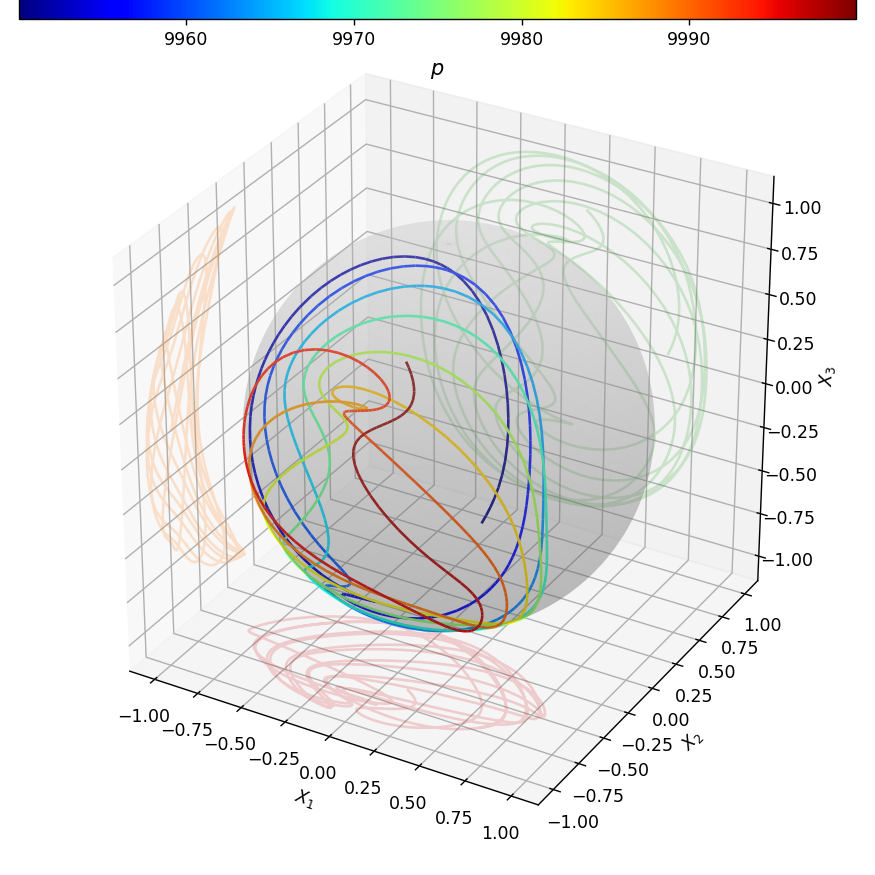

In [3]:
fig

True

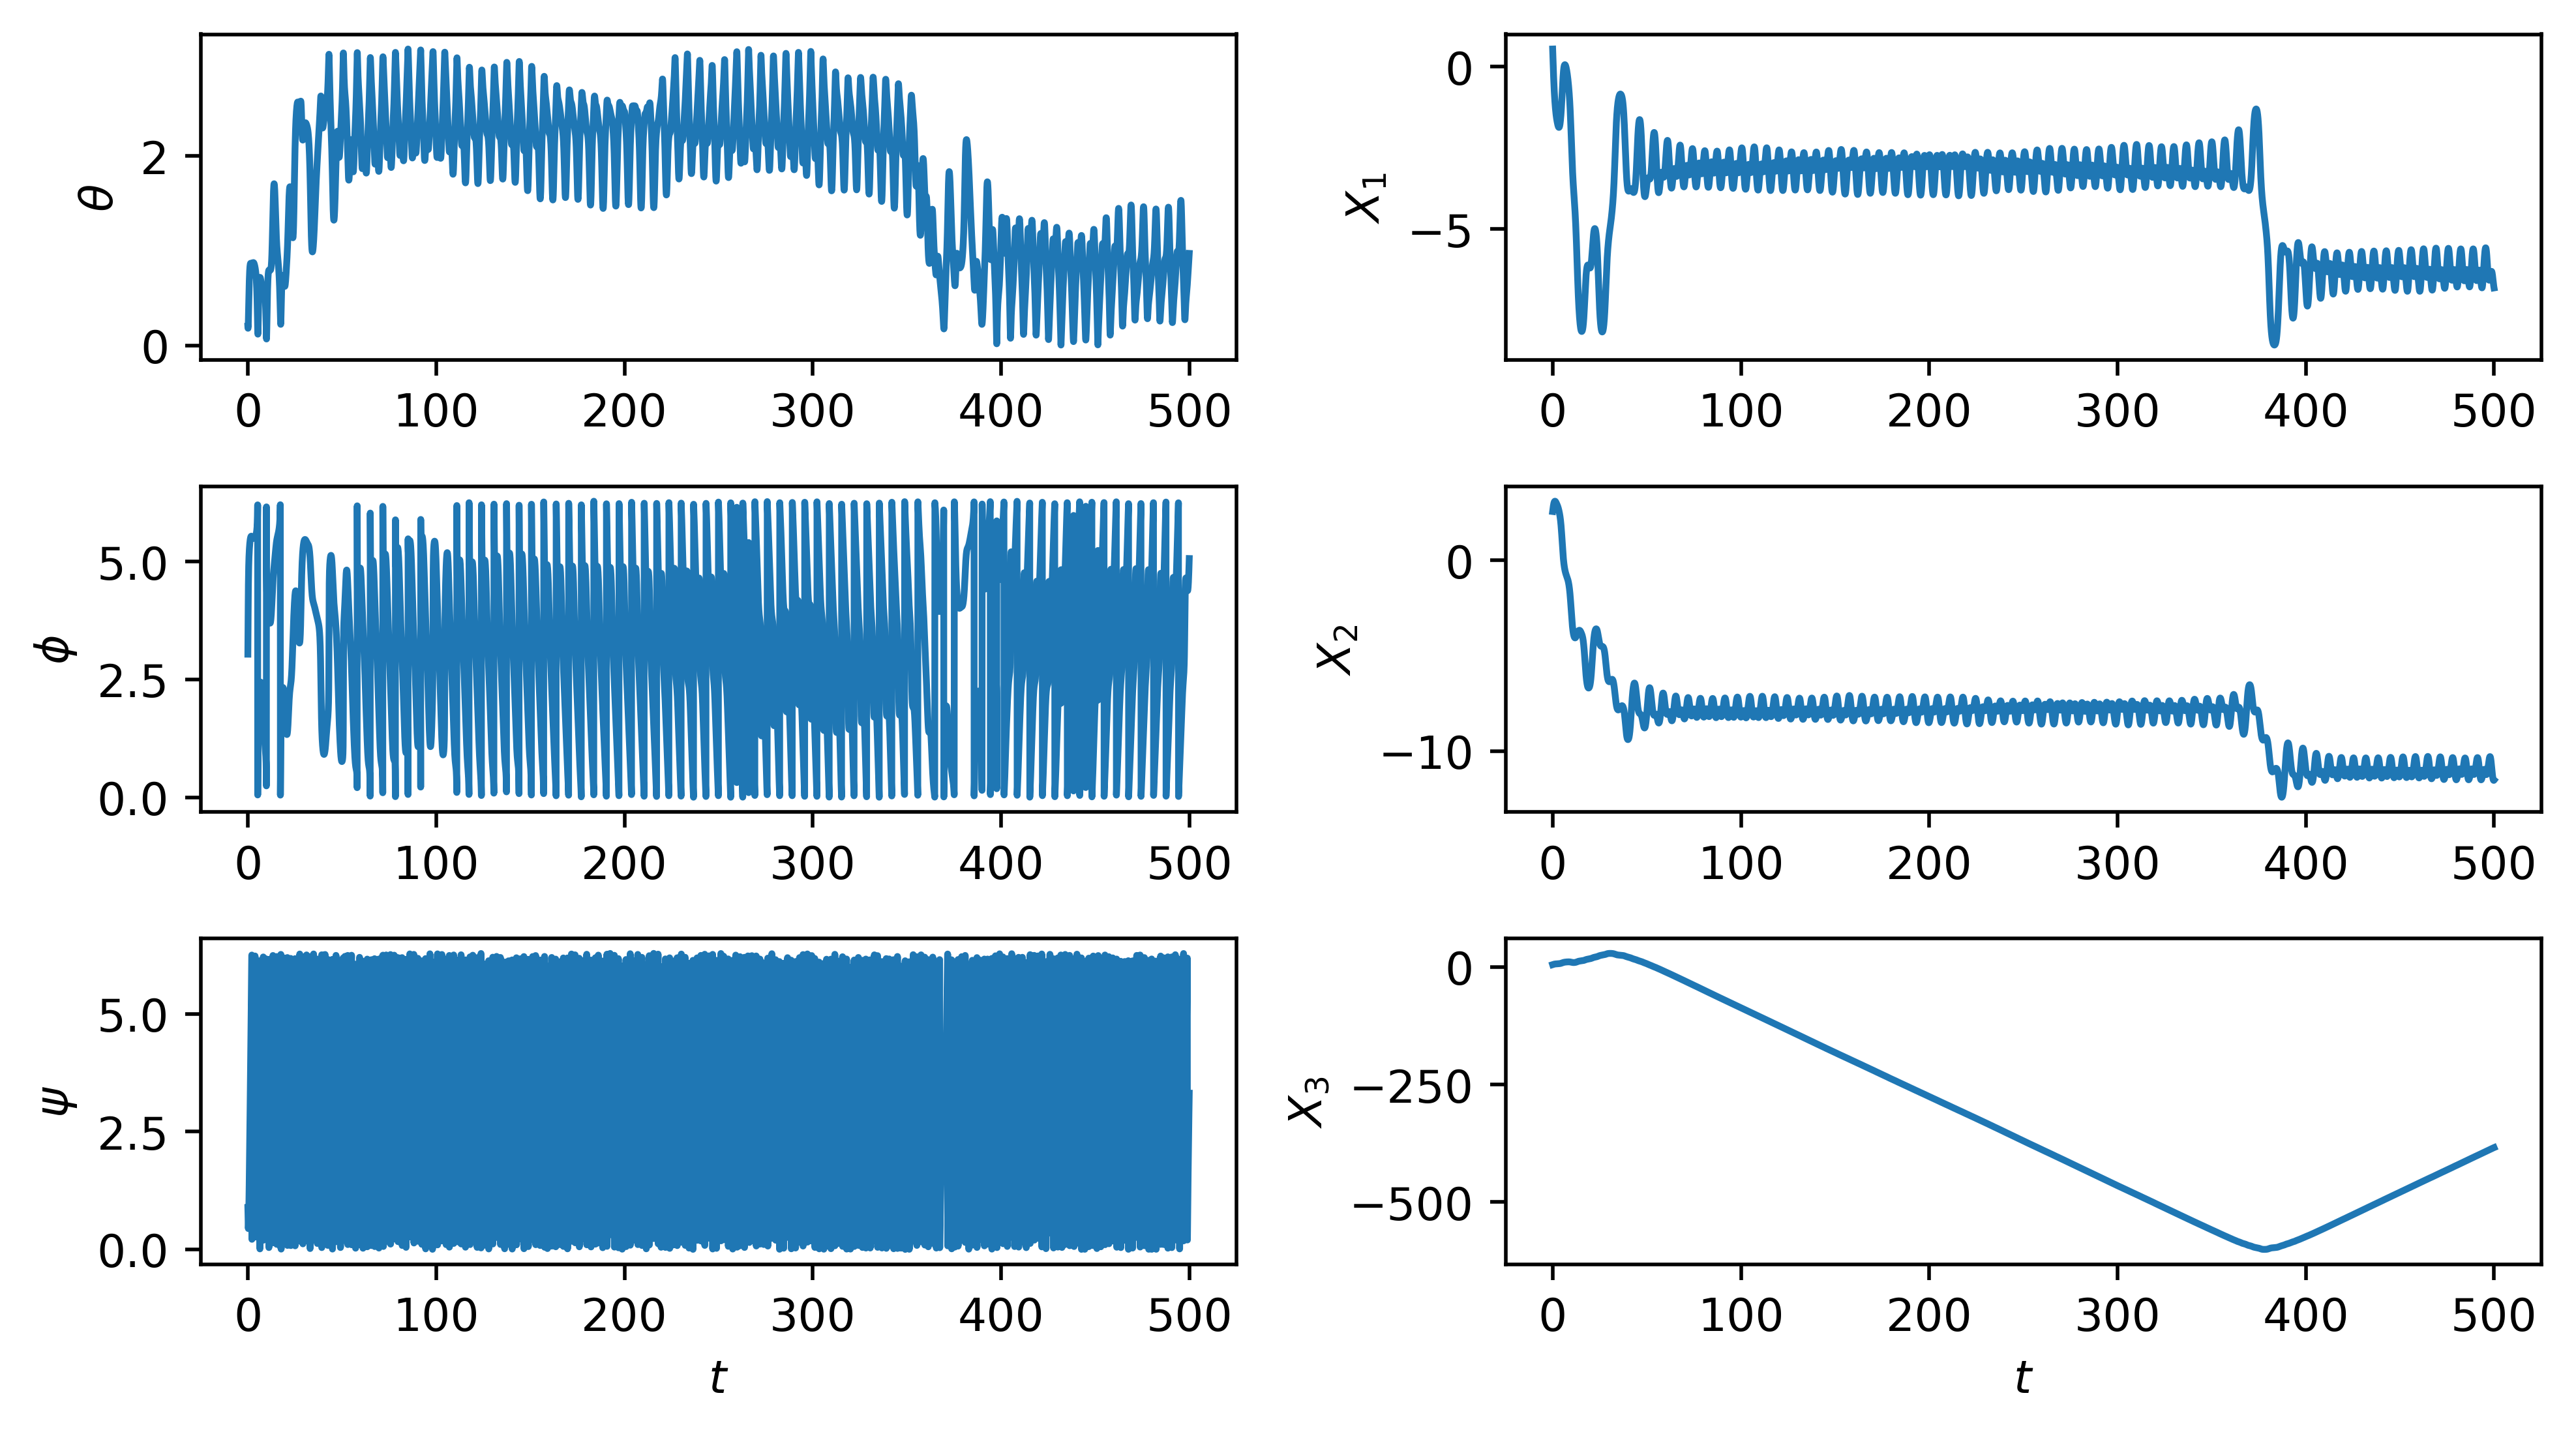

In [25]:
%matplotlib inline
figsize, dpi = np.array((16, 9)) * 0.5, 500 
base_t_min, base_t_max = 0, 500

tidx = (base_t >= base_t_min) * (base_t <= base_t_max)
show_handle = spf_bf.core_show_thphps_X_t
spf_bf.show_fun(show_handle, base_t[tidx], base_thphps[tidx], base_psi_t[tidx], base_X[tidx], 
                figsize=figsize, dpi=dpi)

## simulation and plot

In [24]:
t_theta, t_phi, t_psi = 0.066816, 2.598166, 5.352264
max_t = 5000
update_fun='5bs'
rtol, atol = 1e-9, 1e-12
# rtol, atol = 1e-12, 1e-15
eval_dt = 0.000001
save_every = 1
omega_tail = 0
table_name2 = 'ecoC01B05_baseFlow'
# table_name2 = 'ellipsoidB05_baseFlow_theo'
# table_name2 = 'ellipsoidB05_act_baseFlow'
ABCFlowkwargs = {'ABC_A': 1, 
                 'ABC_B': 1, 
                 'ABC_C': 1, 
                 'name':  'ABCFlowProblem'}
ini_center = np.array((0.494299, 4.127003, 4.681817))
problemHandle=jm.ABCFlowProblem

tdata = spf_bf.do_GivenFlowObj(t_theta, t_phi, t_psi, max_t, table_name=table_name2, 
                            update_fun=update_fun, rtol=rtol, atol=atol, eval_dt=eval_dt, 
                            save_every=save_every, tqdm_fun=tqdm_notebook, 
                            omega_tail=omega_tail, ini_center=ini_center, 
                            problemHandle=problemHandle, **ABCFlowkwargs)


<IPython.core.display.Javascript object>


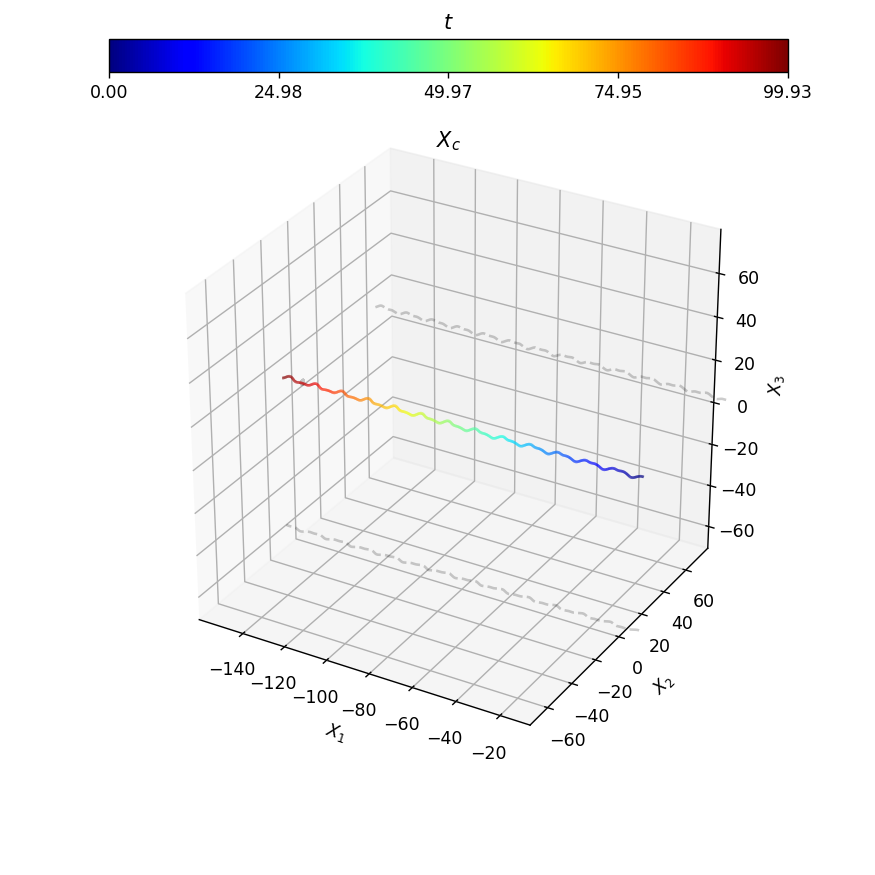

True

In [23]:
figsize, dpi = np.array((10, 10)) * 0.5, 100
base_t, base_dt, base_X, base_thphps, base_U, base_W, base_psi_t = tdata

base_t_min, base_t_max = 0, np.inf
tidx = (base_t > base_t_min) * (base_t < base_t_max)

show_handle = spf_bf.core_show_X
spf_bf.show_fun(show_handle, base_t[tidx], base_X[tidx], base_U[tidx], dpi=dpi)